# Predicting Activity with a Multilayer Perceptron

... i.e., time-independent model, full dataset

In [126]:
import numpy
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# fix random seed for reproducibility
seed = 66
numpy.random.seed(seed)

data = pandas.read_csv("../data/processed/train.csv")
notnull_data = data[data.notnull().all(axis=1)]
train = notnull_data.values
data2 = pandas.read_csv("../data/processed/test.csv")
notnull_data2 = data2[data2.notnull().all(axis=1)]
test = notnull_data2.values

In [127]:
X_train = train[:,3:7558].astype(float)
#X_train = train[:,3:13].astype(float)
Y_train = train[:,7558]
X_test = test[:,3:7558].astype(float)
#X_test = test[:,3:13].astype(float)
Y_test = test[:,7558]

# One hot encoding of the response variable (using dummy variables)
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y_train)
encoded_Y_train = encoder.transform(Y_train)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_train = np_utils.to_categorical(encoded_Y_train)
encoder.fit(Y_test)
encoded_Y_test = encoder.transform(Y_test)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_test = np_utils.to_categorical(encoded_Y_test)

# Sanity check on matrix dimensions, after droppinig null/nans
#print X_train.shape #(4472, 7555)
#print Y_test.shape #(1044, )
#print dummy_y_test.shape # (1044, 5)


In [132]:
from keras.layers import Dropout
from keras.constraints import maxnorm
from keras.optimizers import SGD

# baseline model
def create_baseline():
    # create model
    model = Sequential()
    model.add(Dense(200, input_dim=7555, init='uniform', activation='tanh', W_constraint=maxnorm(4)))
    model.add(Dense(20, init='uniform', activation='tanh', W_constraint=maxnorm(4)))
    model.add(Dense(5, init='uniform', activation='sigmoid'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Apply dropout regularization, it is overfitting!
def create_dropout():
    # create model
    model = Sequential()
    model.add(Dropout(0.2, input_shape=(7555,)))
    model.add(Dense(200, init='uniform', activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(20, init='uniform', activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(5, init='uniform', activation='sigmoid'))
    # Compile model, with larger learning rate and momentum, as recommended by the original paper
    sgd = SGD(lr=0.01, momentum=0.9, decay=0.0, nesterov=False)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

# Apply dropout regularization, it is overfitting!
def create_dropout_decay():
    # create model
    model = Sequential()
    model.add(Dropout(0.2, input_shape=(7555,)))
    model.add(Dense(200, init='uniform', activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(20, init='uniform', activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(5, init='uniform', activation='sigmoid'))
    # Compile model, with larger learning rate and momentum, as recommended by the original paper
    sgd = SGD(lr=0.1, momentum=0.9, decay=0.005, nesterov=False)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

# evaluate baseline model with standardized dataset
numpy.random.seed(seed)
#estimators = []
#estimators.append(('standardize', StandardScaler()))
#estimators.append(('mlp', KerasClassifier(build_fn=create_baseline, nb_epoch=10, batch_size=10, verbose=1)))
# We define a pipeline of estimators, in which first the scaler is fitted to the data, then the MLP is applied
#pipeline = Pipeline(estimators)
#kfold = StratifiedKFold(y=Y_train, n_folds=3, shuffle=True, random_state=seed)

#model = create_baseline()
model = create_dropout_decay()
# We standardize on the basis of the training data
scaler = StandardScaler().fit(X_train)
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)
scaler

StandardScaler(copy=True, with_mean=True, with_std=True)

In [133]:
from keras.callbacks import ModelCheckpoint

# To save the best model
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
filepath="weights.best.hdf5"
# Define that the accuracy in cv is monitored, and that weights are stored in a file when max accuracy is achieved
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# Fit the model
history = model.fit(X_train_st, dummy_y_train, validation_data=(X_test_st,dummy_y_test), nb_epoch=20, batch_size=10, verbose=1, callbacks=callbacks_list)
#results = cross_val_score(pipeline, X_train, dummy_y_train, cv=kfold)
#print("Standardized data Acc (in CV training data): %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
# evaluate the model
#scores = pipeline.evaluate(X_test, dummy_y_test)
#print pipeline.metrics_names[1]
#print scores[1]*100
# For other metrics, see http://machinelearningmastery.com/metrics-evaluate-machine-learning-algorithms-python/



Train on 4472 samples, validate on 1044 samples
Epoch 1/20
4472/4472 [==============================] - 20s - loss: 1.3139 - acc: 0.4517 - val_loss: 1.2809 - val_acc: 0.3669
Epoch 2/20
4472/4472 [==============================] - 22s - loss: 1.1968 - acc: 0.4801 - val_loss: 1.2010 - val_acc: 0.4483
Epoch 3/20
4472/4472 [==============================] - 23s - loss: 1.1506 - acc: 0.4975 - val_loss: 1.2024 - val_acc: 0.4406
Epoch 4/20
4472/4472 [==============================] - 24s - loss: 1.0997 - acc: 0.5112 - val_loss: 1.1978 - val_acc: 0.4856
Epoch 5/20
4472/4472 [==============================] - 26s - loss: 1.0604 - acc: 0.5203 - val_loss: 1.1917 - val_acc: 0.4990
Epoch 6/20
4472/4472 [==============================] - 28s - loss: 1.0287 - acc: 0.5394 - val_loss: 1.1844 - val_acc: 0.5077
Epoch 7/20
4472/4472 [==============================] - 29s - loss: 0.9947 - acc: 0.5581 - val_loss: 1.1708 - val_acc: 0.5268
Epoch 8/20
4472/4472 [==============================] - 31s - loss: 0.

(1044, 5)
Accuracy:
0.537356321839
Confusion matrix:
[[147   8  29  11   5]
 [  8 180  97   5  35]
 [ 42  72 186  11  26]
 [ 39   9  23  14  10]
 [  5  26  21   1  34]]
AUC score:
0.782980197618


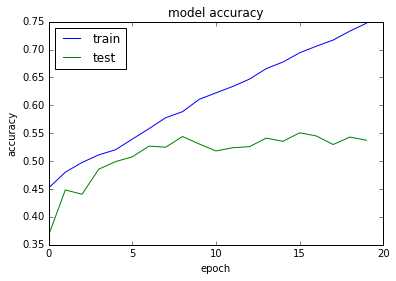

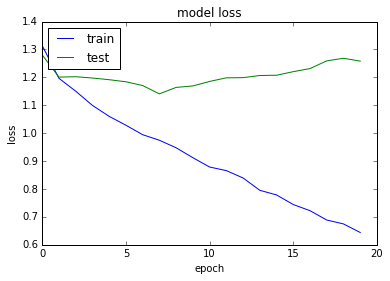

In [134]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score

# Other performance/accuracy metrics
Y_pred = model.predict(X_test_st)
print Y_pred.shape

# Accuracy
print('Accuracy:')
print(accuracy_score(numpy.argmax(dummy_y_test, axis=1), numpy.argmax(Y_pred, axis=1)))


# Confusion matrix
cm = confusion_matrix(numpy.argmax(dummy_y_test, axis=1), numpy.argmax(Y_pred, axis=1))
numpy.set_printoptions(precision=2)
print('Confusion matrix:')
print(cm)

# AUC
roc = roc_auc_score(dummy_y_test, Y_pred, average='macro')
print('AUC score:')
print(roc)
    

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()



## MLPs using PCA as inputs

In [140]:
from sklearn.decomposition import PCA

pca = PCA(n_components=20)
PCAtrain = pca.fit_transform(X_train_st)
PCAtest = pca.transform(X_test_st)

print 'Variance explained:'
print pca.explained_variance_ratio_
print 'Total variance explained by 20 components:'
print sum(pca.explained_variance_ratio_)
#print PCAtrain.shape
#print PCAtest.shape

Variance explained:
[ 0.2   0.08  0.04  0.02  0.02  0.02  0.01  0.01  0.01  0.01  0.01  0.01
  0.01  0.01  0.01  0.01  0.01  0.01  0.    0.  ]


In [142]:
# Apply dropout regularization, it is overfitting!
def create_dropout_decay_PCA():
    # create model
    model = Sequential()
    model.add(Dropout(0.2, input_shape=(20,)))
    model.add(Dense(50, init='uniform', activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(20, init='uniform', activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(5, init='uniform', activation='sigmoid'))
    # Compile model, with larger learning rate and momentum, as recommended by the original paper
    sgd = SGD(lr=0.1, momentum=0.9, decay=0.001, nesterov=False)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

model = create_dropout_decay_PCA()

# To save the best model
# serialize model to JSON
model_json = model.to_json()
with open("modelpca.json", "w") as json_file:
    json_file.write(model_json)
filepath="weightspca.best.hdf5"
# Define that the accuracy in cv is monitored, and that weights are stored in a file when max accuracy is achieved
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]



Train on 4472 samples, validate on 1044 samples
Epoch 1/100
4472/4472 [==============================] - 1s - loss: 1.4147 - acc: 0.3862 - val_loss: 1.4371 - val_acc: 0.3716
Epoch 2/100
4472/4472 [==============================] - 1s - loss: 1.3851 - acc: 0.4157 - val_loss: 1.3330 - val_acc: 0.3908
Epoch 3/100
4472/4472 [==============================] - 1s - loss: 1.3664 - acc: 0.4153 - val_loss: 1.2946 - val_acc: 0.4291
Epoch 4/100
4472/4472 [==============================] - 1s - loss: 1.3431 - acc: 0.4182 - val_loss: 1.2809 - val_acc: 0.4310
Epoch 5/100
4472/4472 [==============================] - 1s - loss: 1.3484 - acc: 0.4235 - val_loss: 1.2830 - val_acc: 0.4052
Epoch 6/100
4472/4472 [==============================] - 1s - loss: 1.3214 - acc: 0.4356 - val_loss: 1.2737 - val_acc: 0.4301
Epoch 7/100
4472/4472 [==============================] - 1s - loss: 1.3171 - acc: 0.4466 - val_loss: 1.2865 - val_acc: 0.4330
Epoch 8/100
4472/4472 [==============================] - 1s - loss: 1.

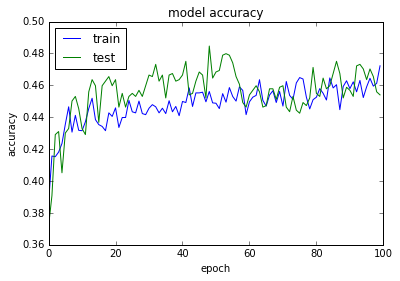

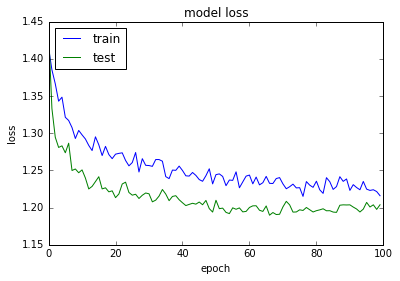

In [143]:
# Fit the model
history = model.fit(PCAtrain, dummy_y_train, 
                    validation_data=(PCAtest,dummy_y_test), 
                    nb_epoch=100, batch_size=10, verbose=1, 
                    callbacks=callbacks_list)

# Other performance/accuracy metrics
Y_pred = model.predict(PCAtest)
print Y_pred.shape

# Accuracy
print('Accuracy:')
print(accuracy_score(numpy.argmax(dummy_y_test, axis=1), numpy.argmax(Y_pred, axis=1)))


# Confusion matrix
cm = confusion_matrix(numpy.argmax(dummy_y_test, axis=1), numpy.argmax(Y_pred, axis=1))
numpy.set_printoptions(precision=2)
print('Confusion matrix:')
print(cm)

# AUC
roc = roc_auc_score(dummy_y_test, Y_pred, average='macro')
print('AUC score:')
print(roc)
    

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()